In [1]:

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import copy
import tarfile
import requests
import re
import sys
import warnings
warnings.filterwarnings('ignore')
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.font_manager as font_manager
import cv2
from tensorflow.keras import optimizers
import pickle
from numpy.linalg import norm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



PLOT WEIGHTS - SUNGLASSES BD NET

In [2]:
!wget https://github.com/vbabushkin/ECE_GY_9163_Machine_Learning_for_Cyber_Security_Project/raw/main/models/sunglasses_bd_net.h5
!wget https://github.com/vbabushkin/ECE_GY_9163_Machine_Learning_for_Cyber_Security_Project/raw/main/models/sunglasses_bd_weights.h5

bd_model_path = "/content/sunglasses_bd_net.h5"
bd_model_weights_path = "/content/sunglasses_bd_weights.h5"
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
bd_model = tf.keras.models.load_model(bd_model_path)
bd_model.load_weights(bd_model_weights_path)

--2022-05-02 06:15:58--  https://github.com/vbabushkin/ECE_GY_9163_Machine_Learning_for_Cyber_Security_Project/raw/main/models/sunglasses_bd_net.h5
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vbabushkin/ECE_GY_9163_Machine_Learning_for_Cyber_Security_Project/main/models/sunglasses_bd_net.h5 [following]
--2022-05-02 06:15:59--  https://raw.githubusercontent.com/vbabushkin/ECE_GY_9163_Machine_Learning_for_Cyber_Security_Project/main/models/sunglasses_bd_net.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7274924 (6.9M) [application/octet-stream]
Saving to: ‘sunglasses_bd_net.h5’

sunglasses

In [5]:
def getLayerIndexByName(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx

def thresholdbyfilterweights(model,layer_idx,norm_ord,debug = True):
  fmaps = model.layers[layer_idx].get_weights()[0]

  norms = []
  num_filters=fmaps.shape[-1]
  for i in range(num_filters):
    norms.append(tf.norm(fmaps[:,:,:,i],ord=norm_ord).numpy())
  mean_norm = np.array(norms).mean()
  if debug == True:
   print("Mean Norm of layer : ", mean_norm)
  fidp=[]
  for i in range(num_filters):
    if debug == True:
        print("Weight",i," Norm is : ",norms[i])
    if norms[i]<= mean_norm:
      fidp.append(i)
      

  return norms,fidp


In [23]:
!mkdir weights

In [53]:
!zip -r weights.zip /content/weights

updating: content/weights/ (stored 0%)
updating: content/weights/conv2_L2NORM.png (deflated 8%)
updating: content/weights/conv3_L2NORM.png (deflated 7%)
updating: content/weights/conv1_L2NORM.png (deflated 12%)
updating: content/weights/conv1_L1NORM.png (deflated 11%)
updating: content/weights/conv3_L1NORM.png (deflated 7%)
updating: content/weights/conv2_L1NORM.png (deflated 8%)


Mean Norm of layer :  0.8615057
Weight 0  Norm is :  0.56461704
Weight 1  Norm is :  1.4869287
Weight 2  Norm is :  1.0561976
Weight 3  Norm is :  1.5918816
Weight 4  Norm is :  0.6599999
Weight 5  Norm is :  1.2976242
Weight 6  Norm is :  0.5369121
Weight 7  Norm is :  0.95583314
Weight 8  Norm is :  0.54521954
Weight 9  Norm is :  0.6715044
Weight 10  Norm is :  1.0202688
Weight 11  Norm is :  0.94932365
Weight 12  Norm is :  0.7667998
Weight 13  Norm is :  0.56670105
Weight 14  Norm is :  0.79803914
Weight 15  Norm is :  0.65327823
Weight 16  Norm is :  0.5357681
Weight 17  Norm is :  1.3693076
Weight 18  Norm is :  0.7094253
Weight 19  Norm is :  0.49448445


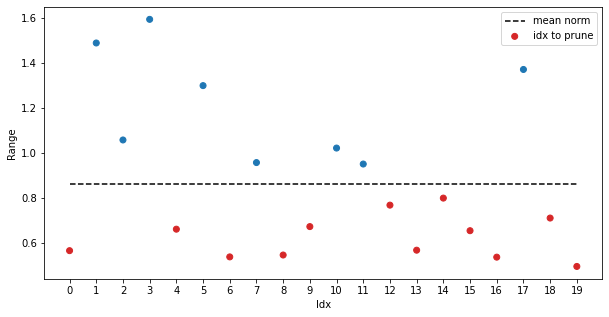

weight Idx to prune:  [0, 4, 6, 8, 9, 12, 13, 14, 15, 16, 18, 19]


In [47]:
conv_layer_name = "conv_1"
norm_ord = "euclidean" # euclidean or 1
norms , idxToPrune =thresholdbyfilterweights(bd_model,1,norm_ord)

idx=[i for i in range(len(norms))]
y_mean = [np.mean(norms)]*len(idx)
clrs = ['tab:red' if (x < np.mean(norms)) else 'tab:blue' for x in norms ]


plt.figure(figsize=(10, 5))
plt.xticks(idx)


plt.plot(idx,y_mean, label='mean norm', linestyle='--',color = 'black')
plt.scatter(idx,norms, color=clrs)
plt.legend(['mean norm','idx to prune'])
plt.xlabel("Idx")
plt.ylabel("Range")

# plt.title("conv1: Weight vs L2 Norm")
plt.savefig("/content/weights/conv1_L2NORM")
plt.show()
print("weight Idx to prune: ",idxToPrune)


Mean Norm of layer :  1.1135275
Weight 0  Norm is :  1.0927261
Weight 1  Norm is :  1.0105559
Weight 2  Norm is :  1.0825583
Weight 3  Norm is :  1.0729642
Weight 4  Norm is :  0.7925741
Weight 5  Norm is :  1.1550001
Weight 6  Norm is :  1.3249322
Weight 7  Norm is :  1.0220188
Weight 8  Norm is :  1.0411652
Weight 9  Norm is :  1.1728153
Weight 10  Norm is :  1.29553
Weight 11  Norm is :  1.0157949
Weight 12  Norm is :  1.5834167
Weight 13  Norm is :  0.95367366
Weight 14  Norm is :  1.0410466
Weight 15  Norm is :  1.2824476
Weight 16  Norm is :  1.0730743
Weight 17  Norm is :  1.1844586
Weight 18  Norm is :  0.98913974
Weight 19  Norm is :  1.1926775
Weight 20  Norm is :  0.9630479
Weight 21  Norm is :  0.9414218
Weight 22  Norm is :  1.0278488
Weight 23  Norm is :  1.0718849
Weight 24  Norm is :  1.0204369
Weight 25  Norm is :  1.352571
Weight 26  Norm is :  0.82722926
Weight 27  Norm is :  1.0949936
Weight 28  Norm is :  1.4610072
Weight 29  Norm is :  1.1724616
Weight 30  Norm is

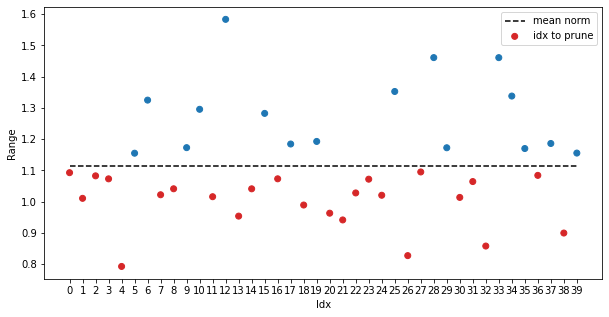

weight Idx to prune:  [0, 1, 2, 3, 4, 7, 8, 11, 13, 14, 16, 18, 20, 21, 22, 23, 24, 26, 27, 30, 31, 32, 36, 38]


In [48]:
conv_layer_name = "conv_2"
norm_ord = "euclidean" # euclidean or 1
norms , idxToPrune =thresholdbyfilterweights(bd_model,getLayerIndexByName(bd_model,conv_layer_name),norm_ord)
idx=[i for i in range(len(norms))]
y_mean = [np.mean(norms)]*len(idx)

clrs = ['tab:red' if (x < np.mean(norms)) else 'tab:blue' for x in norms ]


plt.figure(figsize=(10, 5))
plt.xticks(idx)


plt.plot(idx,y_mean, label='mean norm', linestyle='--',color = 'black')
plt.scatter(idx,norms, color=clrs)
plt.legend(['mean norm','idx to prune'])
plt.xlabel("Idx")
plt.ylabel("Range")
# plt.title("conv1: Weight vs L2 Norm")
plt.savefig("/content/weights/conv2_L2NORM")
plt.show()
print("weight Idx to prune: ",idxToPrune)


Mean Norm of layer :  1.3386534
Weight 0  Norm is :  1.2582285
Weight 1  Norm is :  1.1589143
Weight 2  Norm is :  1.1479741
Weight 3  Norm is :  1.4714835
Weight 4  Norm is :  1.451331
Weight 5  Norm is :  1.3471066
Weight 6  Norm is :  1.8406912
Weight 7  Norm is :  1.3735986
Weight 8  Norm is :  1.3528719
Weight 9  Norm is :  1.2647984
Weight 10  Norm is :  1.554392
Weight 11  Norm is :  1.6655852
Weight 12  Norm is :  1.0274392
Weight 13  Norm is :  1.5421001
Weight 14  Norm is :  1.1703122
Weight 15  Norm is :  1.3848366
Weight 16  Norm is :  1.2073684
Weight 17  Norm is :  1.3465508
Weight 18  Norm is :  1.6477368
Weight 19  Norm is :  1.4109017
Weight 20  Norm is :  1.6037806
Weight 21  Norm is :  1.3373278
Weight 22  Norm is :  1.627698
Weight 23  Norm is :  1.322797
Weight 24  Norm is :  1.3637408
Weight 25  Norm is :  1.5544401
Weight 26  Norm is :  1.2517513
Weight 27  Norm is :  1.2106094
Weight 28  Norm is :  1.2739077
Weight 29  Norm is :  1.666236
Weight 30  Norm is :  1

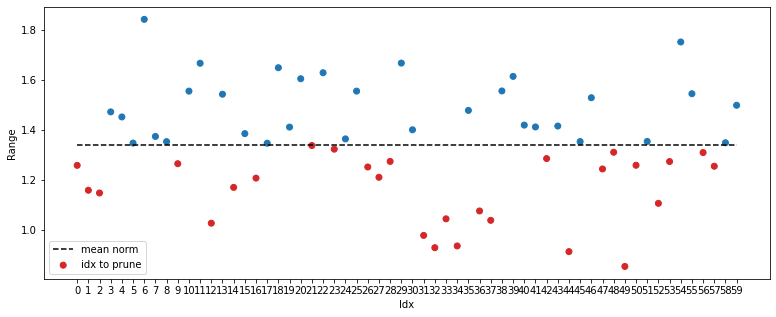

weight Idx to prune:  [0, 1, 2, 9, 12, 14, 16, 21, 23, 26, 27, 28, 31, 32, 33, 34, 36, 37, 42, 44, 47, 48, 49, 50, 52, 53, 56, 57]


In [49]:
conv_layer_name = "conv_3"
norm_ord = "euclidean" # euclidean or 1
norms , idxToPrune =thresholdbyfilterweights(bd_model,getLayerIndexByName(bd_model,conv_layer_name),norm_ord)

idx=[i for i in range(len(norms))]
y_mean = [np.mean(norms)]*len(idx)
clrs = ['tab:red' if (x < np.mean(norms)) else 'tab:blue' for x in norms ]


plt.figure(figsize=(13, 5))
plt.xticks(idx)


plt.plot(idx,y_mean, label='mean norm', linestyle='--',color = 'black')
plt.scatter(idx,norms, color=clrs)
plt.legend(['mean norm','idx to prune'],loc='lower left')
plt.xlabel("Idx")
plt.ylabel("Range")
# plt.title("conv1: Weight vs L2 Norm")
plt.savefig("/content/weights/conv3_L2NORM")
plt.show()
print("weight Idx to prune: ",idxToPrune)


Mean Norm of layer :  5.0790095
Weight 0  Norm is :  3.4124777
Weight 1  Norm is :  8.729607
Weight 2  Norm is :  6.087859
Weight 3  Norm is :  9.43788
Weight 4  Norm is :  3.9741044
Weight 5  Norm is :  7.7693787
Weight 6  Norm is :  3.2045138
Weight 7  Norm is :  5.691951
Weight 8  Norm is :  3.2748604
Weight 9  Norm is :  3.848675
Weight 10  Norm is :  6.028741
Weight 11  Norm is :  5.5048523
Weight 12  Norm is :  4.4897976
Weight 13  Norm is :  3.4351912
Weight 14  Norm is :  4.538523
Weight 15  Norm is :  3.5237768
Weight 16  Norm is :  3.2687187
Weight 17  Norm is :  8.315886
Weight 18  Norm is :  4.1107674
Weight 19  Norm is :  2.9326425


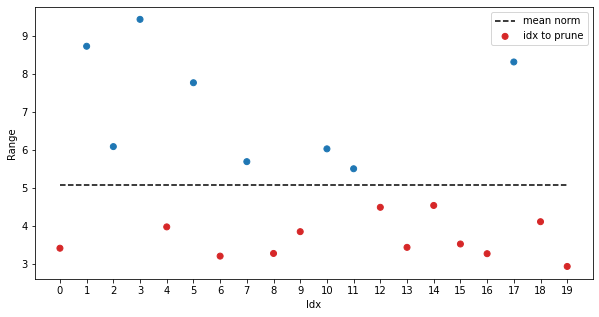

weight Idx to prune:  [0, 4, 6, 8, 9, 12, 13, 14, 15, 16, 18, 19]


In [50]:
conv_layer_name = "conv_1"
norm_ord = 1 # euclidean or 1
norms , idxToPrune =thresholdbyfilterweights(bd_model,getLayerIndexByName(bd_model,conv_layer_name),norm_ord)
# y_mean = [np.mean(norms)]*len(idx)
idx=[i for i in range(len(norms))]
y_mean = [np.mean(norms)]*len(idx)
clrs = ['tab:red' if (x < np.mean(norms)) else 'tab:blue' for x in norms ]


plt.figure(figsize=(10, 5))
plt.xticks(idx)


plt.plot(idx,y_mean, label='mean norm', linestyle='--',color = 'black')
plt.scatter(idx,norms, color=clrs)
plt.legend(['mean norm','idx to prune'],loc='top right')
plt.xlabel("Idx")
plt.ylabel("Range")
# plt.title("conv1: Weight vs L2 Norm")
plt.savefig("/content/weights/conv1_L1NORM")
plt.show()
print("weight Idx to prune: ",idxToPrune)


Mean Norm of layer :  12.177309
Weight 0  Norm is :  11.837303
Weight 1  Norm is :  11.018069
Weight 2  Norm is :  11.863918
Weight 3  Norm is :  12.125632
Weight 4  Norm is :  9.268538
Weight 5  Norm is :  12.826493
Weight 6  Norm is :  14.4936285
Weight 7  Norm is :  11.421001
Weight 8  Norm is :  11.00046
Weight 9  Norm is :  12.577201
Weight 10  Norm is :  14.115664
Weight 11  Norm is :  11.490646
Weight 12  Norm is :  15.982344
Weight 13  Norm is :  10.968406
Weight 14  Norm is :  11.324117
Weight 15  Norm is :  13.880738
Weight 16  Norm is :  11.677586
Weight 17  Norm is :  13.230291
Weight 18  Norm is :  11.25629
Weight 19  Norm is :  12.975637
Weight 20  Norm is :  10.5092
Weight 21  Norm is :  10.80614
Weight 22  Norm is :  11.294532
Weight 23  Norm is :  12.054807
Weight 24  Norm is :  10.786737
Weight 25  Norm is :  14.588337
Weight 26  Norm is :  9.543702
Weight 27  Norm is :  12.256194
Weight 28  Norm is :  15.407294
Weight 29  Norm is :  12.748651
Weight 30  Norm is :  11

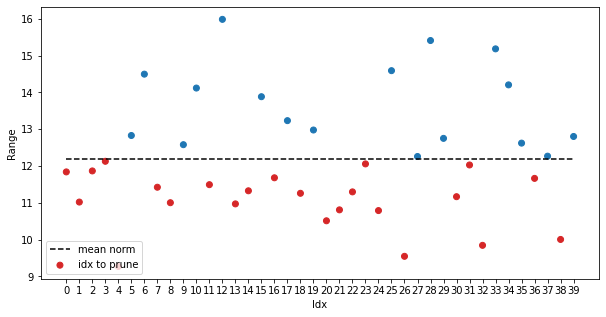

weight Idx to prune:  [0, 1, 2, 3, 4, 7, 8, 11, 13, 14, 16, 18, 20, 21, 22, 23, 24, 26, 30, 31, 32, 36, 38]


In [51]:
conv_layer_name = "conv_2"
norm_ord = 1 # euclidean or 1
norms , idxToPrune =thresholdbyfilterweights(bd_model,getLayerIndexByName(bd_model,conv_layer_name),norm_ord)

idx=[i for i in range(len(norms))]
y_mean = [np.mean(norms)]*len(idx)
clrs = ['tab:red' if (x < np.mean(norms)) else 'tab:blue' for x in norms ]


plt.figure(figsize=(10, 5))
plt.xticks(idx)


plt.plot(idx,y_mean, label='mean norm', linestyle='--',color = 'black')
plt.scatter(idx,norms, color=clrs)
plt.legend(['mean norm','idx to prune'],loc='lower left')
plt.xlabel("Idx")
plt.ylabel("Range")
# plt.title("conv1: Weight vs L2 Norm")
plt.savefig("/content/weights/conv2_L1NORM")
plt.show()
print("weight Idx to prune: ",idxToPrune)


Mean Norm of layer :  20.510454
Weight 0  Norm is :  19.290009
Weight 1  Norm is :  18.305626
Weight 2  Norm is :  18.25827
Weight 3  Norm is :  22.444445
Weight 4  Norm is :  21.754948
Weight 5  Norm is :  20.525345
Weight 6  Norm is :  27.247917
Weight 7  Norm is :  20.702871
Weight 8  Norm is :  20.8049
Weight 9  Norm is :  19.707802
Weight 10  Norm is :  23.85504
Weight 11  Norm is :  25.504053
Weight 12  Norm is :  16.257116
Weight 13  Norm is :  22.784796
Weight 14  Norm is :  18.21241
Weight 15  Norm is :  21.189117
Weight 16  Norm is :  18.266132
Weight 17  Norm is :  20.446777
Weight 18  Norm is :  23.769604
Weight 19  Norm is :  21.967861
Weight 20  Norm is :  23.584728
Weight 21  Norm is :  19.930471
Weight 22  Norm is :  24.160713
Weight 23  Norm is :  20.902887
Weight 24  Norm is :  20.949738
Weight 25  Norm is :  23.334877
Weight 26  Norm is :  19.127913
Weight 27  Norm is :  18.223093
Weight 28  Norm is :  19.839245
Weight 29  Norm is :  24.477398
Weight 30  Norm is :  2

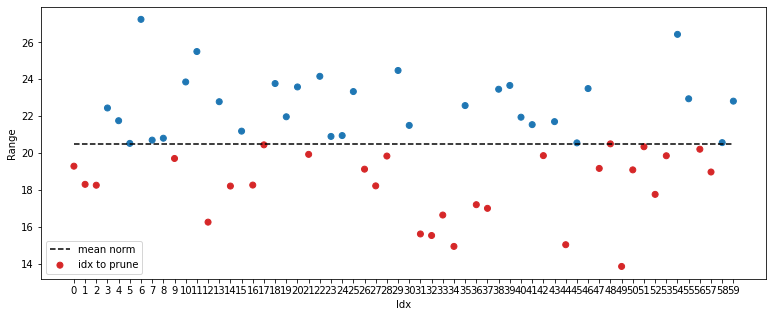

weight Idx to prune:  [0, 1, 2, 9, 12, 14, 16, 17, 21, 26, 27, 28, 31, 32, 33, 34, 36, 37, 42, 44, 47, 48, 49, 50, 51, 52, 53, 56, 57]


In [52]:
conv_layer_name = "conv_3"
norm_ord = 1 # euclidean or 1
norms , idxToPrune =thresholdbyfilterweights(bd_model,getLayerIndexByName(bd_model,conv_layer_name),norm_ord)

idx=[i for i in range(len(norms))]
y_mean = [np.mean(norms)]*len(idx)
clrs = ['tab:red' if (x < np.mean(norms)) else 'tab:blue' for x in norms ]


plt.figure(figsize=(13, 5))
plt.xticks(idx)


plt.plot(idx,y_mean, label='mean norm', linestyle='--',color = 'black')
plt.scatter(idx,norms, color=clrs)
plt.legend(['mean norm','idx to prune'],loc='lower left')
plt.xlabel("Idx")
plt.ylabel("Range")
# plt.title("conv1: Weight vs L2 Norm")
plt.savefig("/content/weights/conv3_L1NORM")
plt.show()
print("weight Idx to prune: ",idxToPrune)


In [ ]:
# load data
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

In [ ]:
def getLayerIndexByName(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx

In [ ]:
def visualize_data(X,y,num_samples=10000):
  num = 10
  np.random.seed(45)
  randIdx = [np.random.randint(num_samples) for i in range(num)]
  num_row = 2
  num_col = 5# plot images
  fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
  for i in range(num):
      ax = axes[i//num_col, i%num_col]
      ax.imshow(X[randIdx[i]].astype('uint8'))
      ax.set_title('label: {:.0f}'.format(y[randIdx[i]]))
      ax.set_xticks([])
      ax.set_yticks([])
  plt.tight_layout()
  plt.show()

In [ ]:
#define data path
data_path="/content/drive/MyDrive/fine-pruning/data/Lab3"
cl_valid_filename = data_path+"/cl/valid.h5"
cl_test_filename = data_path+"/cl/test.h5"
bd_valid_filename = data_path+"/bd/bd_valid.h5"
bd_test_filename = data_path+"/bd/bd_test.h5"

# define model paths
model_folder="/content/drive/MyDrive/fine-pruning/models"
bd_model_path = model_folder+"/bd_net.h5"
bd_model_weights_path = model_folder+"/bd_weights.h5"
fp_model_path = model_folder+"/bd_net_tmp.h5"
fp_model_weights_path = model_folder+"/bd_weights_tmp.h5"


#Load model in memory
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
bd_model = tf.keras.models.load_model(bd_model_path)
bd_model.load_weights(bd_model_weights_path)
fp_model =tf.keras.models.load_model(fp_model_path)
fp_model.load_weights(fp_model_weights_path)


#Load data in memory
cl_x_valid, cl_y_valid = data_loader(cl_valid_filename)
cl_x_test, cl_y_test = data_loader(cl_test_filename)
bd_x_valid, bd_y_valid = data_loader(bd_valid_filename)
bd_x_test, bd_y_test = data_loader(bd_test_filename)



In [ ]:
def thresholdbyfilterweights(X,model,layer_idx,norm_ord,debug = True):
  fmaps = model.layers[layer_idx].get_weights()[0]

  norms = []
  num_filters=fmaps.shape[-1]
  for i in range(num_filters):
    norms.append(tf.norm(fmaps[:,:,:,i],ord=norm_ord).numpy())
  mean_norm = np.array(norms).mean()
  if debug == True:
   print("Mean Norm of layer : ", mean_norm)
  fidp=[]
  for i in range(num_filters):
    if debug == True:
        print("Weight",i," Norm is : ",norms[i])
    if norms[i]<= mean_norm:
      fidp.append(i)
      

  return norms,fidp


In [ ]:
def visualizeWeights(model, dataset, layer_name , pathToSave, suptitleText, num_filters, clbLowLimit = None, clbUpLimit = None):
    # lastPoolLayerIdx = getLayerIndexByName(model, layer_name)
    # tmpModel = Model(inputs=model.inputs, outputs=model.layers[lastPoolLayerIdx].output)
    # feature_maps = tmpModel(dataset)
    # averageActivations = np.mean(feature_maps,0)
    averageActivations = np.mean(model.layers[getLayerIndexByName(model,layer_name)].get_weights()[0],0)
    col = 10# to arrange them in 10 columns and 6 rows
    fig, axs = plt.subplots(int(num_filters / 10), 10, figsize=(12, 8), sharex=False, sharey=False)
    for i in range(averageActivations.shape[2]):
        axs[i // col, i % col].set_title('ch = '+str(i),fontsize=10, y=0.95)
        if clbLowLimit is not None and clbUpLimit is not None:
            im = axs[i // col, i % col ].imshow(averageActivations[:,:,i],vmin=clbLowLimit, vmax=clbUpLimit)
        else:
            im = axs[i // col, i % col ].imshow(averageActivations[:,:,i],vmin=np.min(averageActivations), vmax=np.max(averageActivations))
        axs[i // col, i % col ].invert_yaxis()
        axs[i // col, i % col ].set_axis_off()
        fig.subplots_adjust(right=0.9)
    ax_x_start  = 0.92
    ax_x_width  = 0.02
    ax_y_start  = 0.13
    ax_y_height = 0.75
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im,cax=cbar_ax)
    if clbLowLimit is not None and clbUpLimit is not None:
        clb.mappable.set_clim(clbLowLimit, clbUpLimit)
    else:
        clb.mappable.set_clim(np.min(averageActivations), np.max(averageActivations))
    clb.ax.set_title('', fontsize=14)  # title on top of colorbar
    plt.suptitle(suptitleText, fontsize=12, y=0.97);
    # plt.savefig(pathToSave+'.pdf')
    plt.savefig(pathToSave+'.jpg', dpi=400)
    # return averageActivations

CONV - 1 

Visualizing Norms of weights 

Mean Norm of layer :  0.3615601
Weight 0  Norm is :  0.22974832
Weight 1  Norm is :  0.104918
Weight 2  Norm is :  0.10813549
Weight 3  Norm is :  0.53014064
Weight 4  Norm is :  0.067800835
Weight 5  Norm is :  0.4008661
Weight 6  Norm is :  0.30004358
Weight 7  Norm is :  0.26412705
Weight 8  Norm is :  1.0501739
Weight 9  Norm is :  0.31134713
Weight 10  Norm is :  0.7971708
Weight 11  Norm is :  0.21240115
Weight 12  Norm is :  0.18462792
Weight 13  Norm is :  0.3006844
Weight 14  Norm is :  0.37903342
Weight 15  Norm is :  0.31712276
Weight 16  Norm is :  0.08956224
Weight 17  Norm is :  0.11671068
Weight 18  Norm is :  0.5788059
Weight 19  Norm is :  0.8877812


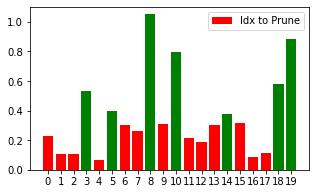

weight Idx to prune:  [0, 1, 2, 4, 6, 7, 9, 11, 12, 13, 15, 16, 17]


In [ ]:
conv_layer_name = "conv_1"
norm_ord = "euclidean" # euclidean or 1
norms , idxToPrune =thresholdbyfilterweights(bd_x_test,bd_model,getLayerIndexByName(bd_model,conv_layer_name),norm_ord)

idx=[i for i in range(len(norms))]
clrs = ['red' if (x < np.mean(norms)) else 'green' for x in norms ]
plt.figure(figsize=(5, 3))
plt.xticks(idx)
plt.bar(idx,norms, color=clrs)
plt.legend(["Idx to Prune"])
# plt.title("conv1: Weight vs L2 Norm")
plt.show()
print("weight Idx to prune: ",idxToPrune)

Mean Norm of layer :  2.0960567
Weight 0  Norm is :  1.4060344
Weight 1  Norm is :  0.58920586
Weight 2  Norm is :  0.6495949
Weight 3  Norm is :  2.940243
Weight 4  Norm is :  0.3598869
Weight 5  Norm is :  2.4686399
Weight 6  Norm is :  1.9134
Weight 7  Norm is :  1.6740397
Weight 8  Norm is :  5.8809094
Weight 9  Norm is :  1.9371886
Weight 10  Norm is :  4.460559
Weight 11  Norm is :  1.3635341
Weight 12  Norm is :  1.0924532
Weight 13  Norm is :  1.9635934
Weight 14  Norm is :  2.165528
Weight 15  Norm is :  2.0075805
Weight 16  Norm is :  0.52427137
Weight 17  Norm is :  0.6783214
Weight 18  Norm is :  3.2229676
Weight 19  Norm is :  4.62318


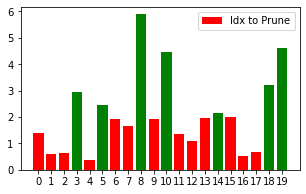

weight Idx to prune:  [0, 1, 2, 4, 6, 7, 9, 11, 12, 13, 15, 16, 17]


In [ ]:
conv_layer_name = "conv_1"
norm_ord = 1 # euclidean or 1
norms , idxToPrune =thresholdbyfilterweights(bd_x_test,bd_model,getLayerIndexByName(bd_model,conv_layer_name),norm_ord)

idx=[i for i in range(len(norms))]
clrs = ['red' if (x < np.mean(norms)) else 'green' for x in norms ]
plt.figure(figsize=(5, 3))
plt.xticks(idx)
plt.bar(idx,norms, color=clrs)
plt.legend(["Idx to Prune"])
# plt.title("conv1: Weight vs L1 Norm")
plt.show()
print("weight Idx to prune: ",idxToPrune)

Mean Norm of layer :  1.0763155
Weight 0  Norm is :  0.86409396
Weight 1  Norm is :  0.36229524
Weight 2  Norm is :  1.2896388
Weight 3  Norm is :  1.4183878
Weight 4  Norm is :  0.96086496
Weight 5  Norm is :  2.3690262
Weight 6  Norm is :  2.102025
Weight 7  Norm is :  0.8442327
Weight 8  Norm is :  2.4063842
Weight 9  Norm is :  0.16031536
Weight 10  Norm is :  1.2274175
Weight 11  Norm is :  0.59341455
Weight 12  Norm is :  1.0012232
Weight 13  Norm is :  0.7805924
Weight 14  Norm is :  0.32963365
Weight 15  Norm is :  0.28863975
Weight 16  Norm is :  1.614779
Weight 17  Norm is :  0.6587674
Weight 18  Norm is :  0.6804253
Weight 19  Norm is :  1.7049024
Weight 20  Norm is :  1.9651744
Weight 21  Norm is :  1.3025334
Weight 22  Norm is :  1.0277898
Weight 23  Norm is :  1.2796973
Weight 24  Norm is :  0.8782859
Weight 25  Norm is :  1.9151236
Weight 26  Norm is :  0.3812674
Weight 27  Norm is :  0.3066253
Weight 28  Norm is :  0.69890815
Weight 29  Norm is :  1.3296165
Weight 30  N

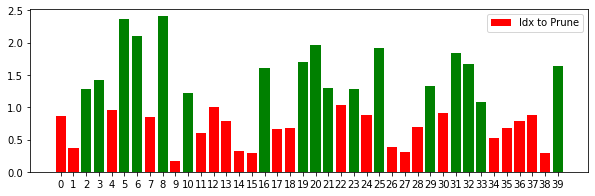

weight Idx to prune:  [0, 1, 4, 7, 9, 11, 12, 13, 14, 15, 17, 18, 22, 24, 26, 27, 28, 30, 34, 35, 36, 37, 38]


In [ ]:
conv_layer_name = "conv_2"
norm_ord = "euclidean" # euclidean or 1
norms , idxToPrune =thresholdbyfilterweights(bd_x_test,bd_model,getLayerIndexByName(bd_model,conv_layer_name),norm_ord)

idx=[i for i in range(len(norms))]
clrs = ['red' if (x < np.mean(norms)) else 'green' for x in norms ]
plt.figure(figsize=(10, 3))
plt.xticks(idx)
plt.bar(idx,norms, color=clrs)
plt.legend(["Idx to Prune"])
# plt.title("conv2: Weight vs L2 Norm")
plt.show()
print("weight Idx to prune: ",idxToPrune)



Mean Norm of layer :  9.35018
Weight 0  Norm is :  7.778217
Weight 1  Norm is :  3.6527326
Weight 2  Norm is :  11.2483015
Weight 3  Norm is :  11.812666
Weight 4  Norm is :  8.273972
Weight 5  Norm is :  20.250832
Weight 6  Norm is :  16.821297
Weight 7  Norm is :  8.315964
Weight 8  Norm is :  19.260393
Weight 9  Norm is :  1.7601709
Weight 10  Norm is :  11.155376
Weight 11  Norm is :  5.865393
Weight 12  Norm is :  9.311484
Weight 13  Norm is :  6.8541565
Weight 14  Norm is :  3.316291
Weight 15  Norm is :  3.0472193
Weight 16  Norm is :  13.757803
Weight 17  Norm is :  6.196817
Weight 18  Norm is :  6.2926874
Weight 19  Norm is :  16.381287
Weight 20  Norm is :  15.272569
Weight 21  Norm is :  11.352963
Weight 22  Norm is :  8.159297
Weight 23  Norm is :  11.2172165
Weight 24  Norm is :  6.993231
Weight 25  Norm is :  14.973843
Weight 26  Norm is :  3.560549
Weight 27  Norm is :  3.0990899
Weight 28  Norm is :  5.8859053
Weight 29  Norm is :  11.596619
Weight 30  Norm is :  7.2320

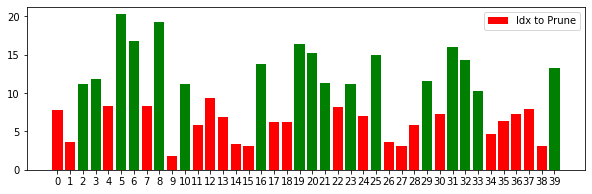

weight Idx to prune:  [0, 1, 4, 7, 9, 11, 12, 13, 14, 15, 17, 18, 22, 24, 26, 27, 28, 30, 34, 35, 36, 37, 38]


In [ ]:
conv_layer_name = "conv_2"
norm_ord = 1 # euclidean or 1
norms , idxToPrune =thresholdbyfilterweights(bd_x_test,bd_model,getLayerIndexByName(bd_model,conv_layer_name),norm_ord)

idx=[i for i in range(len(norms))]
clrs = ['red' if (x < np.mean(norms)) else 'green' for x in norms ]
plt.figure(figsize=(10, 3))
plt.xticks(idx)
plt.bar(idx,norms, color=clrs)
plt.legend(["Idx to Prune"])
# plt.title("conv2: Weight vs L1 Norm")
plt.show()
print("weight Idx to prune: ",idxToPrune)



Mean Norm of layer :  1.3542832
Weight 0  Norm is :  0.21963568
Weight 1  Norm is :  2.3962355
Weight 2  Norm is :  1.2653406
Weight 3  Norm is :  2.6618865
Weight 4  Norm is :  1.9766304
Weight 5  Norm is :  1.9911214
Weight 6  Norm is :  1.9570097
Weight 7  Norm is :  1.7916396
Weight 8  Norm is :  1.7478529
Weight 9  Norm is :  1.0043789
Weight 10  Norm is :  1.7249777
Weight 11  Norm is :  1.774537
Weight 12  Norm is :  0.7666546
Weight 13  Norm is :  0.6695844
Weight 14  Norm is :  0.23263142
Weight 15  Norm is :  0.6435946
Weight 16  Norm is :  2.481443
Weight 17  Norm is :  0.18329866
Weight 18  Norm is :  1.7437826
Weight 19  Norm is :  2.5335584
Weight 20  Norm is :  1.8125026
Weight 21  Norm is :  3.0521204
Weight 22  Norm is :  2.1215818
Weight 23  Norm is :  1.7432646
Weight 24  Norm is :  0.19053657
Weight 25  Norm is :  0.7134379
Weight 26  Norm is :  0.72809005
Weight 27  Norm is :  1.2357119
Weight 28  Norm is :  2.1038072
Weight 29  Norm is :  2.6897013
Weight 30  Norm

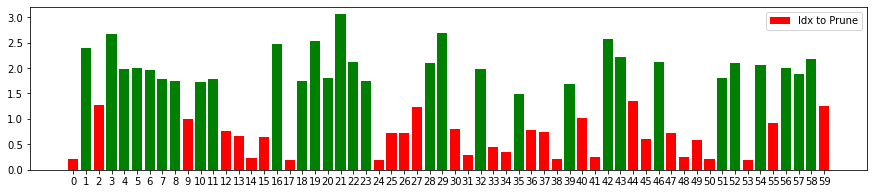

weight Idx to prune:  [0, 2, 9, 12, 13, 14, 15, 17, 24, 25, 26, 27, 30, 31, 33, 34, 36, 37, 38, 40, 41, 44, 45, 47, 48, 49, 50, 53, 55, 59]


In [ ]:
conv_layer_name = "conv_3"
norm_ord = "euclidean" # euclidean or 1
norms , idxToPrune =thresholdbyfilterweights(bd_x_test,bd_model,getLayerIndexByName(bd_model,conv_layer_name),norm_ord)

idx=[i for i in range(len(norms))]
clrs = ['red' if (x < np.mean(norms)) else 'green' for x in norms ]
plt.figure(figsize=(15, 3))
plt.xticks(idx)
plt.bar(idx,norms, color=clrs)
plt.legend(["Idx to Prune"])
# plt.title("conv3: Weight vs L2 Norm")
plt.show()
print("weight Idx to prune: ",idxToPrune)



Mean Norm of layer :  18.6198
Weight 0  Norm is :  3.388104
Weight 1  Norm is :  30.171755
Weight 2  Norm is :  17.055977
Weight 3  Norm is :  39.240765
Weight 4  Norm is :  27.710295
Weight 5  Norm is :  26.332111
Weight 6  Norm is :  27.015676
Weight 7  Norm is :  25.495134
Weight 8  Norm is :  25.03044
Weight 9  Norm is :  15.0568905
Weight 10  Norm is :  24.187908
Weight 11  Norm is :  24.613976
Weight 12  Norm is :  9.415069
Weight 13  Norm is :  7.89579
Weight 14  Norm is :  3.5498102
Weight 15  Norm is :  8.910322
Weight 16  Norm is :  31.889055
Weight 17  Norm is :  2.8046718
Weight 18  Norm is :  25.964888
Weight 19  Norm is :  32.760674
Weight 20  Norm is :  25.481285
Weight 21  Norm is :  47.817894
Weight 22  Norm is :  28.621758
Weight 23  Norm is :  22.38145
Weight 24  Norm is :  2.9304757
Weight 25  Norm is :  8.647457
Weight 26  Norm is :  10.3063345
Weight 27  Norm is :  13.9599285
Weight 28  Norm is :  32.007885
Weight 29  Norm is :  36.28783
Weight 30  Norm is :  9.78

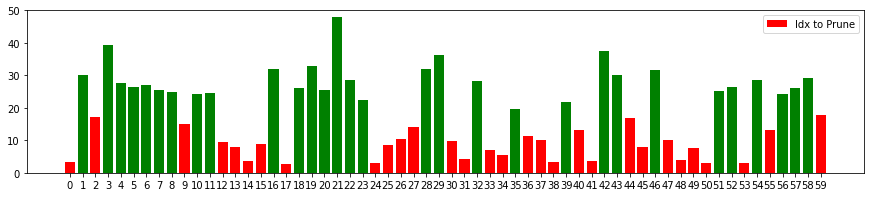

weight Idx to prune:  [0, 2, 9, 12, 13, 14, 15, 17, 24, 25, 26, 27, 30, 31, 33, 34, 36, 37, 38, 40, 41, 44, 45, 47, 48, 49, 50, 53, 55, 59]


In [ ]:
conv_layer_name = "conv_3"
norm_ord = 1 # euclidean or 1
norms , idxToPrune =thresholdbyfilterweights(bd_x_test,bd_model,getLayerIndexByName(bd_model,conv_layer_name),norm_ord)

idx=[i for i in range(len(norms))]
clrs = ['red' if (x < np.mean(norms)) else 'green' for x in norms ]
plt.figure(figsize=(15, 3))
plt.xticks(idx)
plt.bar(idx,norms, color=clrs)
plt.legend(["Idx to Prune"])
# plt.title("conv3: Weight vs L1 Norm")
plt.show()
print("weight Idx to prune: ",idxToPrune)



In [ ]:
pathToSave = "/content/"+conv_layer_name+"-"+str(norm_ord)+"-cl_x_test_on backdoored model"
suptitleText = conv_layer_name+"-"+str(norm_ord)+"-weights_on_cl_x_test_on backdoored model"
visualizeWeights(bd_model,cl_x_test,conv_layer_name,pathToSave,suptitleText,20)

pathToSave = "/content/"+conv_layer_name+"-"+str(norm_ord)+"-bd_x_test on backdoored model"
suptitleText = conv_layer_name+"-"+str(norm_ord)+"-weights on bd_x_test on backdoored model "
visualizeWeights(bd_model,bd_x_test,conv_layer_name,pathToSave,suptitleText,20)



pathToSave = "/content/"+conv_layer_name+"-"+str(norm_ord)+"-cl_x_test_finepruned model"
suptitleText = conv_layer_name+"-"+str(norm_ord)+"-weights on cl_x_test on finepruned model "
visualizeWeights(fp_model,cl_x_test,conv_layer_name,pathToSave,suptitleText,20)



pathToSave = "/content/"+conv_layer_name+"-"+str(norm_ord)+"-bd_x_test on finepruned model"
suptitleText = conv_layer_name+"-"+str(norm_ord)+"-weights on bd_x_test on finepruned model "
visualizeWeights(fp_model,bd_x_test,conv_layer_name,pathToSave,suptitleText,20)


In [ ]:
layer_weights = bd_model.get_layer('conv_1').get_weights()[0]



In [ ]:
layer_norm = []
for i in range(layer_weights[0].shape[-1]):
  layer_norm.append(tf.norm(layer_weights[0][:,:,i],ord="euclidean").numpy())

In [ ]:
layer_norm[6]

0.15131916

In [ ]:
layer_norm = np.array(layer_norm)
print(layer_norm.mean())

np.argsort(layer_norm)

0.17375052


array([ 4, 16,  2,  1, 17, 12, 11,  0,  9, 13,  6,  5,  7, 15, 14, 18,  3,
        8, 10, 19])

In [ ]:
for i in range(layer_weights[0].shape[-1])

In [ ]:
def get_prune_data(backdoored_model,prune_method):
  if prune_method not in {"layerwise-l1norm","layerwise-l2norm","global-l1norm","global-l2norm"}:
    raise ValueError('Invalid `pruning method`')

  conv_layers={'conv_1':1,'conv_2':3,'conv_3':5} #_name of conv layers to be pruned
  weights = []
  prune_dict ={"prune method " : prune_method,
              "conv layers ": conv_layers,
              "norms" :{},
              "layerwise_norm_mean":{},
              "idx to prune":{}
              }
  for conv_layer_name,conv_layer_idx in conv_layers.items():
    # print(conv_layer_name,conv_layer_idx)

    layer_weights = backdoored_model.get_layer(conv_layer_name).get_weights()
    norms=[]
    for i in range(layer_weights[0].shape[-1]):
      if prune_method == "layerwise-l2norm":
        norms.append(tf.norm(layer_weights[0][:,:,:,i],ord="euclidean").numpy())
      elif prune_method == "layerwise-l1norm":
        norms.append(tf.norm(layer_weights[0][:,:,:,i],ord=1).numpy())

    prune_dict["norms"][conv_layer_idx]= norms
    prune_dict["layerwise_norm_mean"][conv_layer_idx]= np.array(norms).mean()
    


  for conv_layer_idx in prune_dict['norms']:
    idx_to_prune=[]
    for kernel_norm_idx in range(len(prune_dict['norms'][conv_layer_idx])):
      
      if prune_dict['layerwise_norm_mean'][conv_layer_idx]< prune_dict['norms'][conv_layer_idx][kernel_norm_idx]:
        idx_to_prune.append(kernel_norm_idx)
    prune_dict['idx to prune'][conv_layer_idx]=idx_to_prune
  
  a_file = open("/content/"+prune_method+"-prune-data.pkl", "wb")
  pickle.dump(prune_dict, a_file)
  a_file.close()
  return prune_dict



In [ ]:
pruning_methods = ["layerwise-l1norm","layerwise-l2norm","global-l1norm","global-l2norm"]
prune_dict = get_prune_data(backdoored_model,"layerwise-l1norm")








  

In [ ]:
backdoored_model.layers[1].get_weights()[0].shape[-1]

20

In [ ]:
prune_dict["idx to prune"]

{1: [3, 5, 8, 10, 14, 18, 19],
 3: [2, 3, 5, 6, 8, 10, 16, 19, 20, 21, 23, 25, 29, 31, 32, 33, 39],
 5: [1,
  3,
  4,
  5,
  6,
  7,
  8,
  10,
  11,
  16,
  18,
  19,
  20,
  21,
  22,
  23,
  28,
  29,
  32,
  35,
  39,
  42,
  43,
  46,
  51,
  52,
  54,
  56,
  57,
  58]}

In [ ]:
global_mean = []
for i in prune_dict["norms"]:
  for j in prune_dict["norms"][i]:
    global_mean.append(j)
print(np.array(global_mean).flatten().mean())

12.77597


In [ ]:
np.array(layer_weights[0]).flatten().shape

(21600,)

In [ ]:
layer_weights=backdoored_model.get_layer('conv_1').get_weights()
print(tf.norm(layer_weights[0].flatten(),ord="euclidean"))


tf.Tensor(2.0188012, shape=(), dtype=float32)


In [ ]:
layer_weights[0][:,:,:,0].mean()

-0.029292382

In [ ]:
import pickle


a_file = open("/content/layerwise-l2norm-prune-data.pkl", "wb")
pickle.dump(prune_dict, a_file)
a_file.close()

a_file = open("/content/layerwise-l2norm-prune-data.pkl", "rb")
output = pickle.load(a_file)
print(output)


{'prune method ': 'layerwise-l2norm', 'conv layers ': {'conv_1': 1, 'conv_2': 3, 'conv_3': 5}, 'norms': {1: [0.22974834, 0.10491801, 0.1081355, 0.53014064, 0.067800835, 0.40086606, 0.30004358, 0.26412705, 1.0501739, 0.31134713, 0.7971708, 0.21240115, 0.1846279, 0.30068436, 0.3790334, 0.3171228, 0.089562245, 0.11671068, 0.5788059, 0.88778126], 3: [0.86409396, 0.3622952, 1.2896388, 1.4183878, 0.960865, 2.3690264, 2.1020248, 0.8442326, 2.4063842, 0.16031535, 1.2274175, 0.59341455, 1.0012231, 0.7805924, 0.32963362, 0.28863975, 1.614779, 0.65876746, 0.68042535, 1.7049025, 1.9651746, 1.3025334, 1.0277898, 1.2796973, 0.8782859, 1.9151236, 0.38126743, 0.30662528, 0.69890827, 1.3296165, 0.9064629, 1.8462039, 1.6654202, 1.0860597, 0.5278583, 0.68421197, 0.78263324, 0.87498033, 0.29264194, 1.6440668], 5: [0.21963568, 2.3962357, 1.2653407, 2.6618862, 1.9766304, 1.9911213, 1.9570098, 1.7916394, 1.747853, 1.004379, 1.7249777, 1.7745372, 0.7666546, 0.66958445, 0.23263142, 0.6435946, 2.481443, 0.18329